## Density Estimation


Relates to all of the probabilities we have been discussing. Will impact classification, clustering and many other operations. 

Question is: how do we find clusters or estimate density efficiently?

<u> The _K-means_ algorithm </u>

The first approach for finding clusters that is always taught is $K$-means (simple and works well)

$K$-means partitions points into $K$ disjoint subsets ($C_k$) with each subset containing $N_k$
points 


It minimizes the objective/cost/likelihood function,
$\sum_{k=1}^K \sum_{i \in C_k} || x_i - \mu_k ||^2$

$\mu_k = \frac{1}{N_k} \sum_{i \in C_k} x_i$ is the mean of the
points in set $C_k$


_Procedure:_

1. define the number of clusters $K$
2. choose the centroid, $\mu_k$, of each of the $K$ clusters
3. assign each point to the cluster that it is closest to
4. update the centroid of each cluster by recomputing $\mu_k$ according to the new assignments.
5. goto (3) until there are no new assignments.

Global optima are not guaranteed but the process never increases the sum-of-squares error.

Typically run multiple times with different starting values for the
centroids of $C_k$.

/Users/ajc/miniconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


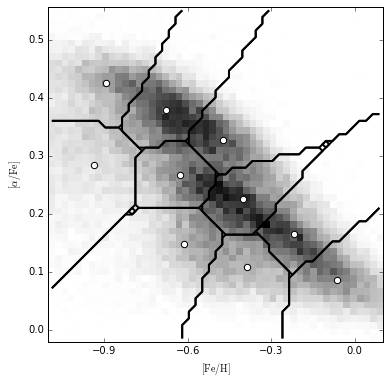

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
from scipy.stats import norm

from sklearn.cluster import KMeans
from sklearn import preprocessing

from astroML.datasets import fetch_sdss_sspp

#------------------------------------------------------------
# Get data
data = fetch_sdss_sspp(cleaned=True)
X = np.vstack([data['FeH'], data['alphFe']]).T

# truncate dataset for speed
X = X[::5]

#------------------------------------------------------------
# Compute a 2D histogram  of the input
H, FeH_bins, alphFe_bins = np.histogram2d(data['FeH'], data['alphFe'], 50)

#------------------------------------------------------------
# Compute the KMeans clustering
n_clusters = 10

scaler = preprocessing.StandardScaler()
clf = KMeans(n_clusters)
clf.fit(scaler.fit_transform(X))

#------------------------------------------------------------
# Visualize the results
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot()

# plot density
ax = plt.axes()
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[FeH_bins[0], FeH_bins[-1],
                  alphFe_bins[0], alphFe_bins[-1]],
          cmap=plt.cm.binary)

# plot cluster centers
cluster_centers = scaler.inverse_transform(clf.cluster_centers_)
ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1],
           s=40, c='w', edgecolors='k')

# plot cluster boundaries
FeH_centers = 0.5 * (FeH_bins[1:] + FeH_bins[:-1])
alphFe_centers = 0.5 * (alphFe_bins[1:] + alphFe_bins[:-1])

Xgrid = np.meshgrid(FeH_centers, alphFe_centers)
Xgrid = np.array(Xgrid).reshape((2, 50 * 50)).T

H = clf.predict(scaler.transform(Xgrid)).reshape((50, 50))

for i in range(n_clusters):
    Hcp = H.copy()
    flag = (Hcp == i)
    Hcp[flag] = 1
    Hcp[~flag] = 0

    ax.contour(FeH_centers, alphFe_centers, Hcp, [-0.5, 0.5],
               linewidths=2, colors='k')

ax.xaxis.set_major_locator(plt.MultipleLocator(0.3))
ax.set_xlim(-1.101, 0.101)
ax.set_ylim(alphFe_bins[0], alphFe_bins[-1])

ax.set_xlabel(r'$\rm [Fe/H]$')
ax.set_ylabel(r'$\rm [\alpha/Fe]$')

plt.show()

** How do you choose the number of clusters?**

## Nearest neighbor estimation

Simple (simplest?) density estimator heavily used in astrophysics (cluster detection, large scale structure measures) 

For each point we find the distance to the $K$th-nearest neighbor, $d_K$. **Note: we are not choosing clusters here**



Implied point density at an arbitrary position $x$ is

$\hat{f}_K(x)  = {K \over V_D(d_K)}$

with $V_D$ the volume. The assumption is that the density is locally constant. Can write it as

$\hat{f}_K(x)  = {C \over d_K^D}$

and calculate $C$ by setting the sum of the product of $\hat{f}_K(x)$ and pixel volume equal to the total number of data points. 

Error on $\hat{f}_K(x)$ is $\sigma_f = K^{1/2}/V_D (d_K)$ 

Fractional (relative) error is $\sigma_f/\hat{f} = 1/K^{1/2}$.

*   fractional accuracy increases with $K$ at  expense of the spatial resolution (bias variance trade-off)
*   effective resolution scales with $K^{1/D}$

Method can be improved by considering distances to _all_ $K$ nearest neighbors 

$\hat{f}_K(x) = {C \over \sum_{i=1}^K d_i^D}$

Normalization when  computing local density without regard to overall mean density
is

$C  =  \frac{K\, (K + 1)}{2 V_D(r)}$


/Users/ajc/miniconda3/lib/python3.5/site-packages/astroML/density_estimation/density_estimation.py:74: UserWarning: The KDE class is deprecated as of version 0.2 and will be removed in version 0.3. Upgrade to scikit-learn version >0.14 and use sklearn.neighbors.KernelDensity instead.
  warnings.warn("The KDE class is deprecated as of version 0.2 and will "
/Users/ajc/miniconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


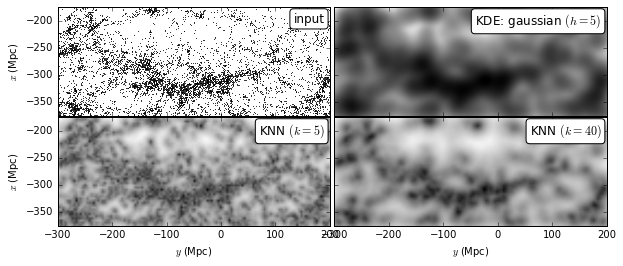

In [3]:
# Author: Jake VanderPlas <vanderplas@astro.washington.edu>
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

from scipy.spatial import cKDTree

from astroML.datasets import fetch_great_wall
from astroML.density_estimation import KDE, KNeighborsDensity
#------------------------------------------------------------
# Fetch the great wall data
X = fetch_great_wall()

#------------------------------------------------------------
# Create  the grid on which to evaluate the results
Nx = 50
Ny = 125
xmin, xmax = (-375, -175)
ymin, ymax = (-300, 200)

#------------------------------------------------------------
# Evaluate for several models
Xgrid = np.vstack(map(np.ravel, np.meshgrid(np.linspace(xmin, xmax, Nx),
                                            np.linspace(ymin, ymax, Ny)))).T

kde = KDE(metric='gaussian', h=10)
dens_KDE = kde.fit(X).eval(Xgrid).reshape((Ny, Nx))

knn5 = KNeighborsDensity('bayesian', 5)
dens_k5 = knn5.fit(X).eval(Xgrid).reshape((Ny, Nx))

knn40 = KNeighborsDensity('bayesian', 40)
dens_k40 = knn40.fit(X).eval(Xgrid).reshape((Ny, Nx))

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(9, 4.0))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.14, top=0.9,
                    hspace=0.01, wspace=0.01)

# First plot: scatter the points
ax1 = plt.subplot(221, aspect='equal')
ax1.scatter(X[:, 1], X[:, 0], s=1, lw=0, c='k')
ax1.text(0.98, 0.95, "input", ha='right', va='top',
         transform=ax1.transAxes, fontsize=12,
         bbox=dict(boxstyle='round', ec='k', fc='w'))

# Second plot: KDE
ax2 = plt.subplot(222, aspect='equal')
ax2.imshow(dens_KDE.T, origin='lower', norm=LogNorm(),
           extent=(ymin, ymax, xmin, xmax), cmap=plt.cm.binary)
ax2.text(0.98, 0.95, "KDE: gaussian $(h=5)$", ha='right', va='top',
         transform=ax2.transAxes, fontsize=12,
         bbox=dict(boxstyle='round', ec='k', fc='w'))

# Third plot: KNN, k=5
ax3 = plt.subplot(223, aspect='equal')
ax3.imshow(dens_k5.T, origin='lower', norm=LogNorm(),
           extent=(ymin, ymax, xmin, xmax), cmap=plt.cm.binary)
ax3.text(0.98, 0.95, "KNN $(k=5)$", ha='right', va='top',
         transform=ax3.transAxes, fontsize=12,
         bbox=dict(boxstyle='round', ec='k', fc='w'))

# Fourth plot: KNN, k=40
ax4 = plt.subplot(224, aspect='equal')
ax4.imshow(dens_k40.T, origin='lower', norm=LogNorm(),
           extent=(ymin, ymax, xmin, xmax), cmap=plt.cm.binary)
ax4.text(0.98, 0.95, "KNN $(k=40)$", ha='right', va='top',
         transform=ax4.transAxes, fontsize=12,
         bbox=dict(boxstyle='round', ec='k', fc='w'))

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xlim(ymin, ymax - 0.01)
    ax.set_ylim(xmin, xmax)

for ax in [ax1, ax2]:
    ax.xaxis.set_major_formatter(plt.NullFormatter())

for ax in [ax3, ax4]:
    ax.set_xlabel('$y$ (Mpc)')

for ax in [ax2, ax4]:
    ax.yaxis.set_major_formatter(plt.NullFormatter())

for ax in [ax1, ax3]:
    ax.set_ylabel('$x$ (Mpc)')

plt.show()

## Estimating the density non-parametrically

Effectively an enhancement to histograms (piecewise constant or top-hat kernel) in multidimensional space

**Kernel Density Estimation**

$N(x) = \frac{1}{Nh^D} \sum_{i=1}^N  K\left( \frac{d(x,x_i)}{h} \right),$

K: kernel (defined by the bandwidth h) is any smooth function which is positive at all values

Too narrow a kernel, too spiky the results (high variance)

Too broad a kernel, too smooth or washed out the results (bias)

_Common kernels_

Gaussian: $ K(u) = \frac{1}{(2\pi)^{D/2}} e^{- u^2 / 2}$ D: dimension

Tophat: $ K(u) = \left\{
  \begin{array}{ll}
    \frac{1}{V_D(r)} & {\rm if}\ u \le r,\\
    0                & {\rm if}\ u > r,
  \end{array}
  \right.$
  
Exponential: $  K(u) = \frac{1}{D!\, V_D(r)}e^{-|u|}$ 

with $V_D(r)$ the volume of a hypersphere radius $r$;  $V_D(r) = \frac{2r^D\pi^{D/2}}{D\  \Gamma(D/2)}$

<img src="figures/funcs.png">

Perhaps surprisingly the primary feature is the bandwidth of these distributions not the exact shape. Choosing the bandwidth is usually done through cross-validation


/Users/ajc/miniconda3/lib/python3.5/site-packages/astroML/density_estimation/density_estimation.py:74: UserWarning: The KDE class is deprecated as of version 0.2 and will be removed in version 0.3. Upgrade to scikit-learn version >0.14 and use sklearn.neighbors.KernelDensity instead.
  warnings.warn("The KDE class is deprecated as of version 0.2 and will "
/Users/ajc/miniconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


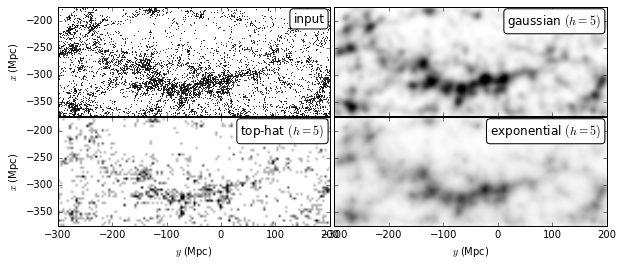

In [4]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

from scipy.spatial import cKDTree
from scipy.stats import gaussian_kde

from astroML.datasets import fetch_great_wall
from astroML.density_estimation import KDE

#------------------------------------------------------------
# Fetch the great wall data
X = fetch_great_wall()

#------------------------------------------------------------
# Create  the grid on which to evaluate the results
Nx = 50
Ny = 125
xmin, xmax = (-375, -175)
ymin, ymax = (-300, 200)

#------------------------------------------------------------
# Evaluate for several models
Xgrid = np.vstack(map(np.ravel, np.meshgrid(np.linspace(xmin, xmax, Nx),
                                            np.linspace(ymin, ymax, Ny)))).T

kde1 = KDE(metric='gaussian', h=5)
dens1 = kde1.fit(X).eval(Xgrid).reshape((Ny, Nx))

kde2 = KDE(metric='tophat', h=1)
dens2 = kde2.fit(X).eval(Xgrid).reshape((Ny, Nx))

kde3 = KDE(metric='exponential', h=5)
dens3 = kde3.fit(X).eval(Xgrid).reshape((Ny, Nx))

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(9, 4.0))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.14, top=0.9,
                    hspace=0.01, wspace=0.01)

# First plot: scatter the points
ax1 = plt.subplot(221, aspect='equal')
ax1.scatter(X[:, 1], X[:, 0], s=1, lw=0, c='k')
ax1.text(0.98, 0.95, "input", ha='right', va='top',
         transform=ax1.transAxes, fontsize=12,
         bbox=dict(boxstyle='round', ec='k', fc='w'))

vmin = 0.
vmax= 1.

# Second plot: gaussian kernel
ax2 = plt.subplot(222, aspect='equal')
ax2.imshow(dens1.T, origin='lower', vmin=vmin, vmax=vmax,
           extent=(ymin, ymax, xmin, xmax), cmap=plt.cm.binary)
ax2.text(0.98, 0.95, "gaussian $(h=5)$", ha='right', va='top',
         transform=ax2.transAxes, fontsize=12,
         bbox=dict(boxstyle='round', ec='k', fc='w'))

# Third plot: top-hat kernel
ax3 = plt.subplot(223, aspect='equal')
ax3.imshow(dens2.T, origin='lower', vmin=vmin, vmax=vmax,
           extent=(ymin, ymax, xmin, xmax), cmap=plt.cm.binary)
ax3.text(0.98, 0.95, "top-hat $(h=5)$", ha='right', va='top',
         transform=ax3.transAxes, fontsize=12,
         bbox=dict(boxstyle='round', ec='k', fc='w'))

# Fourth plot: exponential kernel
ax4 = plt.subplot(224, aspect='equal')
ax4.imshow(dens3.T, origin='lower', vmin=vmin, vmax=vmax,
           extent=(ymin, ymax, xmin, xmax), cmap=plt.cm.binary)
ax4.text(0.98, 0.95, "exponential $(h=5)$", ha='right', va='top',
         transform=ax4.transAxes, fontsize=12,
         bbox=dict(boxstyle='round', ec='k', fc='w'))

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xlim(ymin, ymax - 0.01)
    ax.set_ylim(xmin, xmax)

for ax in [ax1, ax2]:
    ax.xaxis.set_major_formatter(plt.NullFormatter())

for ax in [ax3, ax4]:
    ax.set_xlabel('$y$ (Mpc)')

for ax in [ax2, ax4]:
    ax.yaxis.set_major_formatter(plt.NullFormatter())

for ax in [ax1, ax3]:
    ax.set_ylabel('$x$ (Mpc)')

plt.show()

## Mixture Models: Gaussian

Mixture models use the sum of functions to represent the density distributions - used in defining the density, classifications, cloning of a data set....

Gaussian mixture models (GMMs) are the most common implementation of mixture models

$\rho(\mathbf{x}) = N\, p(\mathbf{x})
  = N\, \sum_{j=1}^M \alpha_j \mathcal{N}(\mu_j, \Sigma_j)$
  
with  $p(\mathbf{x}) = \sum_j \alpha_j \mathcal{N}(\mathbf{x}|\mathbf{\mu}_{j},\mathbf{\Sigma}_{j})$

and

$\mathcal{N}(\mathbf{x}|\mathbf{\mu}_j,\mathbf{\Sigma}_j) =
  \frac{1}{\sqrt{(2\pi)^D\mbox{det}(\mathbf{\Sigma}_j)}}
      \exp\Big(-\frac{1}{2}(\mathbf{x}-\mathbf{\mu})^T\mathbf{\Sigma}_j^{-1}(\mathbf{x}-\mathbf{\mu})\Big)\, $



where the model consists of $M$ Gaussians with locations $\mu_j$
and covariances $\Sigma_j$. The log-likelihood is straightforward to define by this model.

<u> _Expectation maximization_ </u> is typically employed to solve for the mixture of Gaussians


- _Expectation_

  - Given a set of Gaussians compute the “expected” classes of all points

- _Maximization_

  - Estimate the MLE of $\mu$, amplitude, and $\Sigma$ given the data’s class membership 

Iterative proceedure until variance does not change. Guaranteed to converge - but not to the correct answer

/Users/ajc/miniconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:57: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/ajc/miniconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/ajc/miniconda3/lib/python3.5/site-packages/sklearn/mixture/base.py:237: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


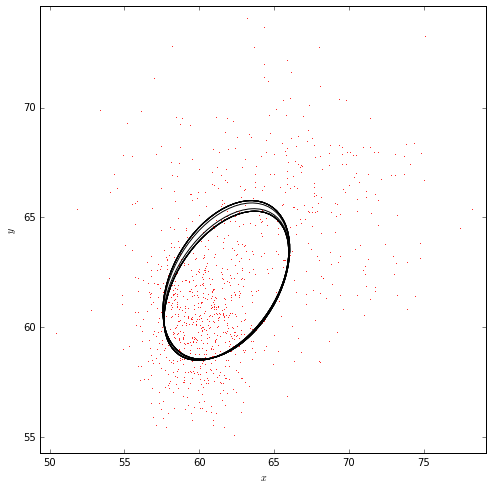

In [6]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm
from sklearn.mixture import GaussianMixture, GMM
from astroML.utils import convert_2D_cov
from astroML.plotting.tools import draw_ellipse
plt.ion()

#------------------------------------------------------------
# Set up the dataset
#  We'll use scikit-learn's Gaussian Mixture Model to sample
#  data from a mixture of Gaussians.  The usual way of using
#  this involves fitting the mixture to data: we'll see that
#  below.  Here we'll set the internal means, covariances,
#  and weights by-hand.

# we'll define clusters as (mu, sigma1, sigma2, alpha, frac)
clusters = [((60, 60), 2, 2, np.pi / 2, 0.6),
            ((65, 65), 5, 3, 0., 0.4),]

gmm_input = GMM(len(clusters), covariance_type='full')
gmm_input.means_ = np.array([c[0] for c in clusters])
gmm_input.covars_ = np.array([convert_2D_cov(*c[1:4]) for c in clusters])
gmm_input.weights_ = np.array([c[4] for c in clusters])
gmm_input.weights_ /= gmm_input.weights_.sum()
gmm_input.converged_ = True
#------------------------------------------------------------
# Compute and plot the results
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
fig.canvas.draw()

Nclusters = len(clusters)
Npts = 1000

X = gmm_input.sample(Npts)

def fitAndPlot(X, n_components=2, n_iter=0):
    ax.plot(X[:, 0], X[:, 1], '.', c='red', ms=1, zorder=1)
    ax.set_xlim(X[:,0].min(), X[:,0].max())
    ax.set_ylim(X[:,1].min(), X[:,1].max())
    ax.set_ylabel('$y$')
    ax.set_xlabel('$x$')
    fig.canvas.draw()
    
    for n in np.arange(1, n_iter, 3):

        clf = GaussianMixture(n_components=2, max_iter=n, random_state=0, init_params='random')
        clf.fit(X)
        #print "%i points convergence:" % Npts, clf.converged_ 

        # scatter the points

        # plot the components
        for i in range(clf.n_components):
            mean = clf.means_[i]
            cov = clf.covariances_[i]
            if cov.ndim == 1:
                cov = np.diag(cov)
            draw_ellipse(mean, cov, ax=ax, scales=[1], fc='none', ec='k', zorder=2)
        fig.canvas.draw()

fitAndPlot(X, n_components=2, n_iter=20)


## How do we choose the number of components

Typically used as a a density estimation and not as a way of determining the number of Gaussians in a distribution (e.g. imagine what would happen with a single cluster and a uniform background)

AIC, BIC, and cross-validation are often used to define the number of parameters (though this is rarely well defined)

Specifying the number of components (or clusters) is a relatively
poorly posed question. It is rare to find distinct, isolated  Gaussian clusters of data  (almost all distributions are continuous). 


@pickle_results: using precomputed results from 'GMM_metallicity.pkl'
best fit converged: True
n_components =  13


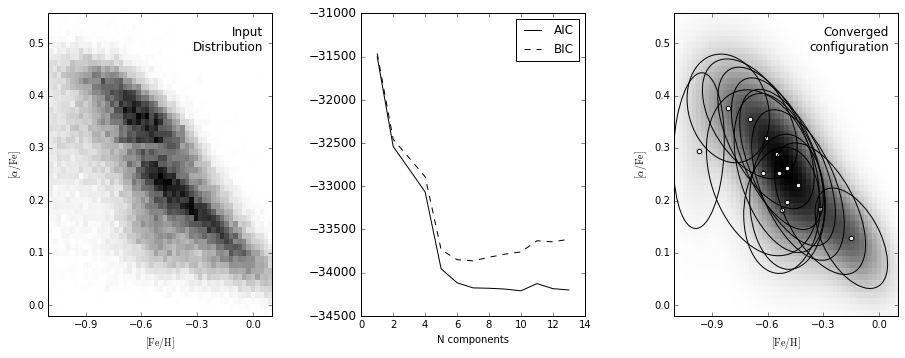

In [7]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm

from sklearn.mixture import GMM

from astroML.datasets import fetch_sdss_sspp
from astroML.decorators import pickle_results
from astroML.plotting.tools import draw_ellipse

# Suppress deprecation warnings
import warnings
warnings.filterwarnings("ignore")

#------------------------------------------------------------
# Get the Segue Stellar Parameters Pipeline data
data = fetch_sdss_sspp(cleaned=True)
X = np.vstack([data['FeH'], data['alphFe']]).T

# truncate dataset for speed
X = X[::5]

#------------------------------------------------------------
# Compute GMM models & AIC/BIC
N = np.arange(1, 14)


@pickle_results("GMM_metallicity.pkl")
def compute_GMM(N, covariance_type='full', n_iter=1000):
    models = [None for n in N]
    for i in range(len(N)):
        print (N[i])
        models[i] = GMM(n_components=N[i], n_iter=n_iter,
                        covariance_type=covariance_type)
        models[i].fit(X)
    return models

models = compute_GMM(N)

AIC = [m.aic(X) for m in models]
BIC = [m.bic(X) for m in models]

i_best = 12
gmm_best = models[i_best]
print ("best fit converged:", gmm_best.converged_)
print ("n_components =  %i" % N[i_best])

#------------------------------------------------------------
# compute 2D density
FeH_bins = 51
alphFe_bins = 51
H, FeH_bins, alphFe_bins = np.histogram2d(data['FeH'], data['alphFe'],
                                          (FeH_bins, alphFe_bins))

Xgrid = np.array(list(map(np.ravel,
                     np.meshgrid(0.5 * (FeH_bins[:-1]
                                        + FeH_bins[1:]),
                                 0.5 * (alphFe_bins[:-1]
                                        + alphFe_bins[1:]))))).T
log_dens = gmm_best.score(Xgrid).reshape((51, 51))

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(19, 6))
fig.subplots_adjust(wspace=0.4,
                    bottom=0.2, top=0.9,
                    left=0.1, right=0.95)

# plot density
ax = fig.add_subplot(141)
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[FeH_bins[0], FeH_bins[-1],
                  alphFe_bins[0], alphFe_bins[-1]],
          cmap=plt.cm.binary)
ax.set_xlabel(r'$\rm [Fe/H]$')
ax.set_ylabel(r'$\rm [\alpha/Fe]$')
ax.xaxis.set_major_locator(plt.MultipleLocator(0.3))
ax.set_xlim(-1.101, 0.101)
ax.text(0.96, 0.96, "Input\nDistribution", fontsize=12,
        va='top', ha='right', transform=ax.transAxes)

# plot AIC/BIC
ax = fig.add_subplot(142)
ax.plot(N, AIC, '-k', label='AIC')
ax.plot(N, BIC, '--k', label='BIC')
ax.legend(loc=1, prop=dict(size=12))
ax.set_xlabel('N components')
plt.setp(ax.get_yticklabels(), fontsize=12)

# plot best configurations for AIC and BIC
ax = fig.add_subplot(143)
ax.imshow(np.exp(log_dens),
          origin='lower', interpolation='nearest', aspect='auto',
          extent=[FeH_bins[0], FeH_bins[-1],
                  alphFe_bins[0], alphFe_bins[-1]],
          cmap=plt.cm.binary)

ax.scatter(gmm_best.means_[:, 0], gmm_best.means_[:, 1], c='w')
for mu, C, w in zip(gmm_best.means_, gmm_best.covars_, gmm_best.weights_):
    draw_ellipse(mu, C, scales=[1.5], ax=ax, fc='none', ec='k')

    # plot best configurations for AIC and BIC

    
ax.text(0.96, 0.96, "Converged\nconfiguration", fontsize=12,
        va='top', ha='right', transform=ax.transAxes)

ax.set_xlim(-1.101, 0.101)
ax.set_ylim(alphFe_bins[0], alphFe_bins[-1])
ax.xaxis.set_major_locator(plt.MultipleLocator(0.3))
ax.set_xlabel(r'$\rm [Fe/H]$')
ax.set_ylabel(r'$\rm [\alpha/Fe]$')

plt.show()

@pickle_results: using precomputed results from 'great_wall_GMM.pkl'


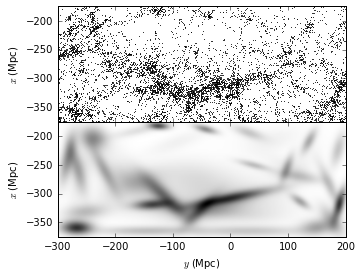

In [84]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.mixture import GMM
from astroML.datasets import fetch_great_wall
from astroML.decorators import pickle_results

#------------------------------------------------------------
# load great wall data
X = fetch_great_wall()


#------------------------------------------------------------
# Create a function which will save the results to a pickle file
#  for large number of clusters, computation will take a long time!
@pickle_results('great_wall_GMM.pkl')
def compute_GMM(n_clusters, n_iter=1000, min_covar=3, covariance_type='full'):
    clf = GMM(n_clusters, covariance_type=covariance_type,
              n_iter=n_iter, min_covar=min_covar)
    clf.fit(X)
    print ("converged:", clf.converged_)
    return clf

#------------------------------------------------------------
# Compute a grid on which to evaluate the result
Nx = 100
Ny = 250
xmin, xmax = (-375, -175)
ymin, ymax = (-300, 200)

Xgrid = np.vstack(map(np.ravel, np.meshgrid(np.linspace(xmin, xmax, Nx),
                                            np.linspace(ymin, ymax, Ny)))).T

#------------------------------------------------------------
# Compute the results
#
# we'll use 100 clusters.  In practice, one should cross-validate
# with AIC and BIC to settle on the correct number of clusters.
clf = compute_GMM(n_clusters=100)
log_dens = clf.score(Xgrid).reshape(Ny, Nx)

#------------------------------------------------------------
# Plot the results
fig = plt.figure()
fig.subplots_adjust(hspace=0, left=0.1, right=0.95, bottom=0.1, top=0.9)

ax = fig.add_subplot(211, aspect='equal')
ax.scatter(X[:, 1], X[:, 0], s=1, lw=0, c='k')

ax.set_xlim(ymin, ymax)
ax.set_ylim(xmin, xmax)

ax.xaxis.set_major_formatter(plt.NullFormatter())
plt.ylabel('$x$ (Mpc)')

ax = fig.add_subplot(212, aspect='equal')
ax.imshow(np.exp(log_dens.T), origin='lower', cmap=plt.cm.binary,
          extent=[ymin, ymax, xmin, xmax])
ax.set_xlabel('$y$ (Mpc)')
ax.set_ylabel('$x$ (Mpc)')

plt.show()

## Hierarchical clustering

Finding all clusters at all scales. 

_Procedure_

1. partition the data into $N$ clusters (one for each point in the
data set)
2. join two of the clusters (resulting in $N-1$ clusters). 
3. repeat until the $N$th partition contains one cluster. 


If two points are in the same cluster at level $m$, and remain together at all subsequent levels, this is known as {\em hierarchical clustering} 

_How do we merge components?_

Many ways to merge the points (minimum distance between points in two clusters, maximum distance between points, average distance between points in two clusters)

The example: $d_{\rm min}(C_k,C_{k'})  =  \min_{x \in C_k, x' \in C_{k'}} ||x-x'||$ is known as the _minimum spanning tree_. Clusters can then be isolated by sorting the links (or edges) by increasing length and deleting those edges longer than some threshold. (``friends-of-friends'' in clustering)



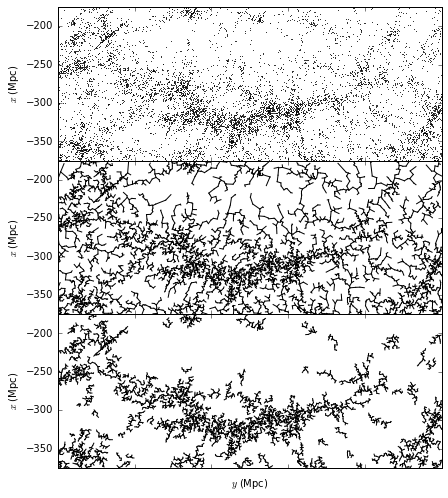

In [8]:
# Author: Jake VanderPlas <vanderplas@astro.washington.edu>
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
import numpy as np
from matplotlib import pyplot as plt

from scipy import sparse
from sklearn.neighbors import kneighbors_graph
from sklearn.mixture import GMM

from astroML.clustering import HierarchicalClustering, get_graph_segments
from astroML.datasets import fetch_great_wall
from astroML.cosmology import Cosmology

from scipy.sparse.csgraph import minimum_spanning_tree, connected_components

#------------------------------------------------------------
# get data
X = fetch_great_wall()

xmin, xmax = (-375, -175)
ymin, ymax = (-300, 200)

#------------------------------------------------------------
# Compute the MST clustering model
n_neighbors = 10
edge_cutoff = 0.9
cluster_cutoff = 30
model = HierarchicalClustering(n_neighbors=10,
                               edge_cutoff=0.9,
                               min_cluster_size=10)
model.fit(X)

n_components = model.n_components_
labels = model.labels_

#------------------------------------------------------------
# Get the x, y coordinates of the beginning and end of each line segment
T_x, T_y = get_graph_segments(model.X_train_,
                              model.full_tree_)
T_trunc_x, T_trunc_y = get_graph_segments(model.X_train_,
                                          model.cluster_graph_)

#----------------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(7, 8))
fig.subplots_adjust(hspace=0, left=0.1, right=0.95, bottom=0.1, top=0.9)

ax = fig.add_subplot(311, aspect='equal')
ax.scatter(X[:, 1], X[:, 0], s=1, lw=0, c='k')
ax.set_xlim(ymin, ymax)
ax.set_ylim(xmin, xmax)
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.set_ylabel('$x$ (Mpc)')

ax = fig.add_subplot(312, aspect='equal')
ax.plot(T_y, T_x, c='k', lw=1)
ax.set_xlim(ymin, ymax)
ax.set_ylim(xmin, xmax)
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.set_xlabel('$y$ (Mpc)')
ax.set_ylabel('$x$ (Mpc)')

ax = fig.add_subplot(313, aspect='equal')
ax.plot(T_trunc_y, T_trunc_x, c='k', lw=1)
#ax.scatter(X[clusters, 1], X[clusters, 0], c=labels[clusters], lw=0)

ax.set_xlim(ymin, ymax)
ax.set_ylim(xmin, xmax)
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.set_xlabel('$y$ (Mpc)')
ax.set_ylabel('$x$ (Mpc)')

plt.show()